去掉csv文件的重复行

In [15]:
import pandas as pd

# 读取CSV文件
data = pd.read_csv('data_51jobs1.csv')

# 基于整行去重，keep='first'表示保留第一次出现的重复行（可根据实际需求选'last'等）
data_unique = data.drop_duplicates(keep='last')

# 保存清洗后的数据为新的CSV文件，可按需修改文件名
data_unique.to_csv('data_51jobs1_filter.csv', index=False)

去除招聘地区为空的行

In [17]:
import pandas as pd

# 读取CSV文件（请替换为你的文件路径）
df = pd.read_csv('data_51jobs1_filter.csv')

# 查看处理前的行数
print(f"处理前的行数：{len(df)}")

# 剔除招聘地区为空的行
# 假设"招聘地区"是数据中对应的列名，若列名不同请修改
df_cleaned = df.dropna(subset=['招聘地区'])

# 查看处理后的行数
print(f"处理后的行数：{len(df_cleaned)}")

# 保存处理后的结果到新的CSV文件
df_cleaned.to_csv('data_51jobs1_filter.csv', index=False)
print("已将处理后的数据保存为 recruitment_data_cleaned.csv")


处理前的行数：681
处理后的行数：620
已将处理后的数据保存为 recruitment_data_cleaned.csv


筛选出符合大模型算法的岗位要求的岗位

In [ ]:
import csv

# 打开源文件和目标文件
with open('LLM_51jobs1.csv', mode='r', encoding='utf-8') as source_file, \
     open('LLM_51jobs1_filtered.csv', mode='w', encoding='utf-8', newline='') as target_file:
    
    # 创建读取器和写入器
    reader = csv.DictReader(source_file)
    writer = csv.DictWriter(target_file, fieldnames=reader.fieldnames)
    
    # 写入表头
    writer.writeheader()
    
    # 遍历每一行数据
    for row in reader:
        job_title = row['岗位名称']
        # 筛选条件：包含"算法"且不包含"开发"和"视觉"
        if '算法' in job_title and '开发' not in job_title and '视觉' not in job_title:
            writer.writerow(row)
            
print("筛选完成，符合条件的数据已保存到 LLM_51jobs1_filtered.csv")

筛选出符合数据标注岗位的数据

In [18]:
import pandas as pd

# 加载数据，需要将此处文件路径替换为你的文件实际路径
df = pd.read_csv('data_51jobs1_filter.csv')

# 去掉岗位名称里带“开发”、“算法”的岗位

cond1 = ~df['岗位名称'].str.contains('开发|算法')
cond2 = df['职位技能关键词'].str.contains('数据标注|数据|标注')
cond3 = df['岗位名称'].str.contains('标注|数据')
cond4 = cond2|cond3
filter_df = df[cond1 & cond4]
# 将结果保存为csv文件，需要将此处文件路径替换为你希望保存的路径
csv_path = 'data_51jobs1_filter1.csv'
filter_df.to_csv(csv_path)

生成图表等东西

In [19]:
# 导入数据处理模块
import pandas as pd
import re
# 导入配置项
from pyecharts import options as opts
# 导入图形
from pyecharts.charts import Pie, Bar, Line

# 读取CSV文件
try:
    df = pd.read_csv('data_51jobs1_filter1.csv')
    print("LLM_51jobs1_filtered.csv文件读取成功！")
    
    # 打印列名以便确认
    print("CSV文件的列名:", df.columns.tolist())
    
    # 检查必要的列是否存在
    if '招聘地区' not in df.columns:
        print("错误: CSV文件中没有'招聘地区'列")
        exit()
    
    # 数据清洗：提取城市名称（去除区名）
    def extract_city(location):
        if pd.isna(location):
            return "未知"
        # 匹配城市名称（通常是2-3个汉字）
        location_str = str(location)
        # 先尝试匹配直辖市和特别行政区
        if any(city in location_str for city in ['北京', '上海', '天津', '重庆', '香港', '澳门']):
            for city in ['北京', '上海', '天津', '重庆', '香港', '澳门']:
                if city in location_str:
                    return city
        # 匹配普通城市（通常是2-3个汉字后跟"市"）
        match = re.search(r'^([\u4e00-\u9fa5]{2,3})市?', location_str)
        if match:
            return match.group(1) + "市"
        return location_str
    
    # 应用清洗函数
    df['清洗后城市'] = df['招聘地区'].apply(extract_city)
    
    # 获取招聘地区分布情况数据（饼图）
    x_area = df['清洗后城市'].value_counts().index.to_list()
    y_area = df['清洗后城市'].value_counts().to_list()

    pie_chart = (
        Pie()
        .add(
            "",
            [list(z) for z in zip(x_area, y_area)],
            center=["40%", "50%"],
        )
        .set_global_opts(
            # 设置可视化标题
            title_opts=opts.TitleOpts(title="招聘地区分布情况"),
            legend_opts=opts.LegendOpts(type_="scroll", pos_left="80%", orient="vertical"),
        )
        .set_series_opts(label_opts=opts.LabelOpts(formatter="{b}: {c}"))
        # 导出可视化效果: 保存html文件
        .render("pie_招聘地区分布情况.html")
    )

    # 改进工作经验统计方法
    if '要求工作经验' in df.columns:
        # 首先打印所有唯一值，以便了解数据分布
        print("工作经验所有唯一值:", df['要求工作经验'].unique())
        
        # 标准化工作经验数据
        def standardize_experience(exp):
            if pd.isna(exp):
                return "未知"
            exp_str = str(exp)
            
            # 处理不需要工作经验的情况
            if any(word in exp_str for word in ['无经验', '经验不限', '不限', '应届', '毕业生']):
                return "无经验要求"
            
            # 处理有经验要求的情况
            match = re.search(r'(\d+)[\-\—~至](\d+)', exp_str)
            if match:
                min_exp = int(match.group(1))
                max_exp = int(match.group(2))
                # 按经验范围分类
                if max_exp <= 1:
                    return "1年以下"
                elif max_exp <= 3:
                    return "1-3年"
                elif max_exp <= 5:
                    return "3-5年"
                elif max_exp <= 10:
                    return "5-10年"
                else:
                    return "10年以上"
            
            # 处理单个数字的情况
            match = re.search(r'(\d+)', exp_str)
            if match:
                exp_num = int(match.group(1))
                if exp_num <= 1:
                    return "1年以下"
                elif exp_num <= 3:
                    return "1-3年"
                elif exp_num <= 5:
                    return "3-5年"
                elif exp_num <= 10:
                    return "5-10年"
                else:
                    return "10年以上"
            
            return exp_str
        
        # 应用标准化函数
        df['标准化工作经验'] = df['要求工作经验'].apply(standardize_experience)
        
        # 统计标准化后的工作经验
        x_work_exp = df['标准化工作经验'].value_counts().index.to_list()
        y_work_exp = df['标准化工作经验'].value_counts().to_list()

        bar_chart = (
            Bar()
            .add_xaxis(x_work_exp)
            .add_yaxis("要求工作经验", y_work_exp, stack="stack1")
            .set_series_opts(label_opts=opts.LabelOpts(is_show=False))
            .set_global_opts(
                title_opts=opts.TitleOpts(title="Bar-要求工作经验分布情况"),
                xaxis_opts=opts.AxisOpts(axislabel_opts=opts.LabelOpts(rotate=-45))  # 旋转x轴标签避免重叠
            )
            .render("bar_要求工作经验分布情况1.html")
        )
        
        # 打印无经验要求的数量
        no_exp_count = (df['标准化工作经验'] == "无经验要求").sum()
        print(f"无经验要求的职位数量: {no_exp_count}")
    else:
        print("警告: CSV文件中没有'要求工作经验'列")

    # 获取要求学历分布情况数据（折线图）
    if '要求学历' in df.columns:
        x_edu = df['要求学历'].value_counts().index.to_list()
        y_edu = df['要求学历'].value_counts().to_list()

        line_chart = (
            Line()
            .add_xaxis(x_edu)
            .add_yaxis("要求学历", y_edu, is_connect_nones=True)
            .set_global_opts(title_opts=opts.TitleOpts(title="Line-要求学历分布"))
            .render("line_要求学历分布.html")
        )
    else:
        print("警告: CSV文件中没有'要求学历'列")
        
    print("图表生成完成！")
    
except FileNotFoundError:
    print("LLM_jobs1.csv文件不存在，请检查文件路径是否正确！")
except pd.errors.ParserError:
    print("LLM_jobs1.csv文件格式可能有问题，无法正确解析，请检查文件内容格式。")
except Exception as e:
    print(f"处理过程中出现错误: {e}")

LLM_51jobs1_filtered.csv文件读取成功！
CSV文件的列名: ['Unnamed: 0', '岗位名称', '招聘地区', '招聘城区', '要求工作经验', '要求学历', '薪水', '发布时间', '公司名称', '公司信息', '职位技能关键词', '职位信息']
工作经验所有唯一值: ['无需经验' '1年及以上' '1年' '1-3年' '3年' '3年及以上' '2年及以上' '1-5年' '5年及以上' '2-7年'
 '2年' '1-2年' '6年及以上' '3-5年' '5-7年' '2-3年' '3-4年' '7年及以上' '2-5年']
无经验要求的职位数量: 0
图表生成完成！


算薪资

In [21]:
import numpy as np
import re
import pandas as pd
df = pd.read_csv('data_51jobs1_filter1.csv')
# 定义函数，将薪水范围转换为年薪
def convert_salary(salary):
    try:
        # 处理按天给钱的情况，假设一年工作250天
        if '元/天' in salary:
            parts = re.findall(r'\d+\.?\d*', salary)
            if len(parts) == 1:
                daily_salary = float(parts[0])
                return daily_salary * 250
            elif len(parts) == 2:
                low_daily_salary = float(parts[0])
                high_daily_salary = float(parts[1])
                return (low_daily_salary + high_daily_salary) / 2 * 250
        
        # 处理包含不同单位（千和万）的情况
        if '千' in salary and '万' in salary:
            parts = re.findall(r'\d+\.?\d*', salary)
            if '千' in salary.split('-')[0] and '万' in salary.split('-')[1]:
                low_salary = float(parts[0]) * 1000
                high_salary = float(parts[1]) * 10000
                return (low_salary * 12 + high_salary * 12) / 2
        
        # 处理包含 '薪' 字的情况，如 '5 - 7 千·14 薪'
        if '薪' in salary:
            parts = re.findall(r'\d+\.?\d*', salary)
            low_salary = float(parts[0])
            high_salary = float(parts[1])
            months = float(parts[2])
            if '万' in salary:
                low_salary *= 10000
                high_salary *= 10000
            elif '千' in salary:
                low_salary *= 1000
                high_salary *= 1000
            return (low_salary * months + high_salary * months) / 2
        
        # 处理仅包含 '千' 字的情况，如 '3.5 - 5.4 千'
        elif '千' in salary:
            parts = re.findall(r'\d+\.?\d*', salary)
            low_salary = float(parts[0]) * 1000
            high_salary = float(parts[1]) * 1000
            return (low_salary * 12 + high_salary * 12) / 2
        
        # 处理仅包含 '万' 字的情况，如 '10 - 15 万'
        elif '万' in salary:
            parts = re.findall(r'\d+\.?\d*', salary)
            low_salary = float(parts[0]) * 10000
            high_salary = float(parts[1]) * 10000
            return (low_salary + high_salary) / 2
        
        else:
            return np.nan
    except:
        return np.nan

# 对薪水列应用函数
df['年薪'] = df['薪水'].apply(convert_salary)

# 计算平均年薪
average_salary = df['年薪'].mean()

print(f"平均年薪：{average_salary:.2f}元")

平均年薪：76080.41元


计算国企和私企数量

In [20]:
import csv
from ast import literal_eval

def count_company_types(filename):
    private_count = 0
    state_owned_count = 0
    total_count = 0
    
    with open(filename, 'r', encoding='utf-8') as file:
        reader = csv.DictReader(file)
        for row in reader:
            total_count += 1
            company_info = row['公司信息']
            
            try:
                # 将字符串转换为列表
                info_list = literal_eval(company_info)
                
                # 检查列表中是否包含"民营"或"国企"
                if '民营' in info_list:
                    private_count += 1
                if '国企' in info_list:
                    state_owned_count += 1
                    
            except (ValueError, SyntaxError):
                # 如果无法解析字符串，跳过该行
                continue
    
    return private_count, state_owned_count, total_count

# 使用函数统计结果
private, state_owned, total = count_company_types('./csv_data/kaifa_jobs1.csv')
print(f"民营企业数量: {private}")
print(f"国有企业数量: {state_owned}")
print(f"总记录数: {total}")

民营企业数量: 644
国有企业数量: 127
总记录数: 1000


筛选出符合要求的岗位（两阶段代码）

In [2]:
import pandas as pd

# 加载数据，需要将此处文件路径替换为你的文件实际路径
df = pd.read_csv('LLMkaifa_51jobs1.csv')

# 设置筛选条件
# cond1 = df['岗位名称'].str.contains('开发')
# cond2 = df['岗位名称'].str.contains('大模型|自然语言|语音|NLP|nlp|LLM')
cond3 = df['职位信息']!= '未找到职位信息'
# 新增条件，岗位名称不能有“算法”字段
cond4 = ~df['岗位名称'].str.contains('算法')

# 根据条件筛选数据
filtered_df = df[cond3 & cond4]

# 将结果保存为 csv 文件，需要将此处文件路径替换为你希望保存的路径
csv_path = 'LLMkaifa_51jobs1_filtered.csv'
filtered_df.to_csv(csv_path)

In [3]:
import pandas as pd
import re  # 用于正则表达式匹配

# 加载数据，替换为你的文件实际路径
df = pd.read_csv('LLMkaifa_51jobs1_filtered.csv')

# 整理大模型和NLP领域高频关键词（覆盖技术、工具、任务、场景等）
keywords = [
    # 大模型核心技术
    '大语言模型', 'LLM', '多模态大模型', 'VLM', '垂直领域大模型', 
    'ChatGLM', 'Qwen', 'Llama', 'DeepSeek', 'Mistral', 'GPT', 'BERT', 'T5',
    '预训练', '微调', 'Fine-tuning', 'SFT', 'RLHF', 'DPO', 'LoRA', 'QLoRA',
    '模型压缩', '量化', '剪枝', '蒸馏', '推理加速', 'vLLM', 'TensorRT-LLM',
    '分布式训练', 'DeepSpeed', 'Megatron-LM', '长上下文', 'MoE',
    
    # NLP核心任务
    '文本分类', '命名实体识别', 'NER', '关系抽取', '语义理解', '情感分析',
    '文本摘要', '机器翻译', '问答系统', 'QA', '对话系统', '多轮对话',
    '检索增强生成', 'RAG', '知识图谱', 'KG', '意图识别', '槽位填充',
    '思维链', 'CoT', 'ReAct',
    
    # 工具框架
    'PyTorch', 'TensorFlow', 'Hugging Face', 'Transformers', 'LangChain',
    'LlamaIndex', 'Milvus', 'FAISS', 'Chroma', 'Weaviate', 'spaCy', 'jieba',
    
    # 工程化部署
    '模型部署', 'ONNX', 'Triton', 'FastAPI', 'Docker', 'Kubernetes',
    'MLOps', 'MLflow', '向量数据库',
    
    # 业务场景
    '智能客服', '知识库问答', '代码生成', '智能助手', 'Agent', '多智能体',
    'Prompt工程', '提示词优化'
]

# 将关键词转换为正则表达式模式（用|分隔，匹配任意一个关键词）
pattern = '|'.join(keywords)

# 筛选条件：职位信息包含上述任意关键词（忽略大小写）
# 使用flags=re.IGNORECASE确保不区分大小写匹配（如LLM和llm都能匹配）
cond = df['职位信息'].str.contains(pattern, flags=re.IGNORECASE, na=False)

# 根据条件筛选数据
filtered_df = df[cond]

# 输出筛选结果数量
print(f"筛选后符合条件的数据量：{filtered_df.shape[0]} 条")

# 保存结果，替换为你希望保存的路径
csv_path = 'LLMkaifa_51jobs1_filtered_keywords.csv'
filtered_df.to_csv(csv_path, index=False)
print(f"筛选结果已保存至：{csv_path}")


筛选后符合条件的数据量：507 条
筛选结果已保存至：LLMkaifa_51jobs1_filtered_keywords.csv


爬虫代码，反扒机制还可以，但是很慢

In [ ]:
# 导入自动化模块
from DrissionPage import ChromiumPage, ChromiumOptions
# 导入格式化输出模块
import json
# 导入csv模块
import csv
import time
import random
import logging

# 配置日志
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    filename='spider_log.log'
)

# 手动定义一些常见的User-Agent，避免依赖fake_useragent
USER_AGENTS = [
    "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36",
    "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/92.0.4515.107 Safari/537.36",
    "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Firefox/89.0",
    "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Edge/91.0.864.59",
    "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/605.1.15 (KHTML, like Gecko) Version/14.1.1 Safari/605.1.15",
    "Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.114 Safari/537.36",
]

# 定义爬取大模型开发岗位的网址链接
urls = [
    "https://we.51job.com/pc/search?jobArea=000000&keyword=%E5%A4%A7%E6%A8%A1%E5%9E%8B%E5%BC%80%E5%8F%91%E5%B2%97&searchType=2&keywordType="
]

# 创建文件对象，所有数据都存入 kaifa_51jobs1.csv
f = open('./kaifa_code/LLMkaifa_51jobs1.csv', mode='w', encoding='utf-8', newline='')
# 字典写入方法
csv_writer = csv.DictWriter(f, fieldnames=[
    '岗位名称',
    '招聘地区',
    '招聘城区',
    '要求工作经验',
    '要求学历',
    '薪水',
    '发布时间',
    '公司名称',
    '公司信息',
    '职位技能关键词',
    '职位信息'
])
# 写入表头
csv_writer.writeheader()

# 配置浏览器选项
co = ChromiumOptions()
# 随机选择一个User-Agent
co.set_user_agent(random.choice(USER_AGENTS))
# 禁用自动化控制特征 - 使用set_argument替代add_argument
co.set_argument("--disable-blink-features=AutomationControlled")
# 添加其他浏览器选项，模拟真实浏览器
co.set_argument("--start-maximized")
co.set_argument("--no-sandbox")
co.set_argument("--disable-dev-shm-usage")

# 实例化浏览器对象
dp = ChromiumPage(co)
main_tab = dp.latest_tab   # 保存主 tab，避免丢失

# 随机等待函数
def random_sleep(min_sec=1, max_sec=2):
    """随机等待一段时间，模拟人类操作"""
    sleep_time = random.uniform(min_sec, max_sec)
    time.sleep(sleep_time)
    return sleep_time

# 随机滚动函数
def random_scroll(page):
    """随机滚动页面，模拟人类浏览行为"""
    scroll_height = page.run_js("return document.body.scrollHeight")
    if scroll_height > 1000:
        # 随机选择几个位置滚动
        for _ in range(random.randint(2, 5)):
            scroll_pos = random.randint(100, scroll_height - 200)
            page.run_js(f"window.scrollTo(0, {scroll_pos})")
            time.sleep(random.uniform(0.5, 1.0))
    # 最后滚动到底部
    page.scroll.to_bottom()
    time.sleep(random.uniform(1, 1.5))

# 重试装饰器
def retry(max_retries=3, delay=2):
    def decorator(func):
        def wrapper(*args, **kwargs):
            for attempt in range(max_retries):
                try:
                    return func(*args, **kwargs)
                except Exception as e:
                    if attempt < max_retries - 1:
                        logging.warning(f"尝试 {attempt+1} 失败: {e}，将在 {delay} 秒后重试")
                        time.sleep(delay)
                    else:
                        logging.error(f"超过最大重试次数 {max_retries}，操作失败: {e}")
                        raise e
        return wrapper
    return decorator

@retry(max_retries=3)
def fetch_job_details(new_tab):
    """获取职位详情，带重试机制"""
    # 随机滚动详情页
    random_scroll(new_tab)
    
    job_description = ""
    job_msg_element = new_tab.ele('css:.bmsg.job_msg.inbox', timeout=10)
    if job_msg_element:
        job_description = job_msg_element.text
        # 清理换行符和多余空格
        job_description = job_description.replace('\n', ' ').replace('\r', ' ').strip()
    else:
        job_description = "未找到职位信息"
    
    return job_description

# 循环处理每个网址
for url in urls:
    try:
        # 访问当前循环对应的网址
        dp.get(url)
        random_sleep(2, 3)  # 给页面足够的加载时间
        
        # 循环翻页
        for page in range(1, 51):
            logging.info(f'正在采集第{page}页（对应网址 {url}）的内容')
            print(f'正在采集第{page}页（对应网址 {url}）的内容')
            
            # 随机滚动页面，模拟浏览
            random_scroll(dp)
            
            # 找到所有岗位块
            divs = dp.eles('css:.joblist-item')
            
            if not divs:
                logging.warning(f"第{page}页未找到岗位信息，可能被反爬")
                # 尝试刷新页面
                dp.refresh()
                random_sleep(5, 8)
                continue
            
            for div in divs:
                try:
                    # 随机小停顿，模拟阅读
                    random_sleep(0.5, 1.5)
                    
                    # 获取岗位基本信息
                    info = div.ele('css:.joblist-item-job').attr('sensorsdata')
                    json_data = json.loads(info)
                    c_name = div.ele('css:.cname').attr('title')
                    c_info_list = [i.text for i in div.eles('css:.dc')]
                    tags = ''.join([j.text for j in div.eles('css:.tag')])
                    
                    # 随机停顿后再点击
                    random_sleep(1, 2)
                    
                    # 点击进入详情页（新 tab）
                    job_link = div.ele('css:.joblist-item-top')
                    job_link.click(by_js=True)
                    random_sleep(2, 3)  # 等待新页面加载
                    
                    # 获取新 tab
                    new_tab = dp.latest_tab
                    dp.activate_tab(new_tab)
                    
                    # 爬取详情页信息
                    job_description = fetch_job_details(new_tab)
                    
                    # 构建数据字典
                    dit = {
                        '岗位名称': json_data['jobTitle'],
                        '招聘地区': json_data['jobArea'],
                        '招聘城区': json_data.get('jobDistrict', ''),  # 有些可能有城区
                        '要求工作经验': json_data['jobYear'],
                        '要求学历': json_data['jobDegree'],
                        '薪水': json_data['jobSalary'],
                        '发布时间': json_data['jobTime'],
                        '公司名称': c_name,
                        '公司信息': ' '.join(c_info_list),  # 将列表转换为字符串
                        '职位技能关键词': tags,
                        '职位信息': job_description
                    }
                    
                    # 写入数据
                    csv_writer.writerow(dit)
                    print(dit)
                    logging.info(f"成功爬取: {json_data['jobTitle']}")
                    
                    # 随机停顿后关闭标签页
                    random_sleep(1, 2)
                    
                    # 关闭详情页，切回主 tab
                    new_tab.close()
                    dp.activate_tab(main_tab)
                    
                except Exception as e:
                    logging.error(f"处理岗位时出错: {e}")
                    print(f"处理岗位时出错: {e}")
                    # 确保回到主 tab
                    try:
                        dp.activate_tab(main_tab)
                    except:
                        pass
                    # 发生错误时，延长等待时间
                    random_sleep(3, 5)
            
            # 判断是否是最后一页，如果是最后一页则不点击下一页
            if page < 50:
                try:
                    # 翻页前随机滚动
                    random_scroll(dp)
                    random_sleep(2, 3)
                    
                    next_btn = dp.ele('css:.btn-next', timeout=10)
                    if next_btn:
                        # 随机点击位置，模拟人类点击
                        next_btn.click(by_js=True)
                        logging.info(f"成功进入第{page+1}页")
                        # 翻页后等待更长时间
                        random_sleep(4, 7)
                    else:
                        logging.info("没有找到下一页按钮，提前结束。")
                        print("没有找到下一页按钮，提前结束。")
                        break
                except Exception as e:
                    logging.error(f"翻页时出错: {e}")
                    print(f"翻页时出错: {e}")
                    # 尝试刷新页面
                    dp.refresh()
                    random_sleep(5, 8)
                    # 尝试再次获取下一页按钮
                    try:
                        next_btn = dp.ele('css:.btn-next', timeout=10)
                        if next_btn:
                            next_btn.click(by_js=True)
                            random_sleep(4, 7)
                        else:
                            break
                    except:
                        break
                    
    except Exception as e:
        logging.error(f"处理URL {url} 时出错: {e}")
        print(f"处理URL {url} 时出错: {e}")
        # 出错后等待更长时间
        random_sleep(10, 15)

# 关闭文件
f.close()
# 关闭浏览器
dp.quit()
print("数据采集完成！")


画词云图

前50个高频词:
数据: 496
标注: 376
办公: 238
定期: 150
计算机: 130
数据分析: 126
软件: 125
交通: 114
工作: 102
员工: 101
弹性: 97
数据处理: 74
通讯: 71
数学: 71
质量: 65
晋升: 65
人工智能: 64
模型: 62
补充: 59
清洗: 58
小时: 56
绩效: 55
审核: 54
在家: 53
奖励: 53
报告: 52
质检: 51
全勤奖: 51
训练: 50
免费: 49
团队: 47
分析: 45
医疗保险: 42
统计学: 42
支持: 40
分类: 38
收集: 37
管理: 36
做五休: 36
学习: 33
团建: 31
班车: 30
法定: 30
统计: 29
理工科: 28
项目: 28
电脑: 27
预处理: 26
底薪: 26
文本: 25


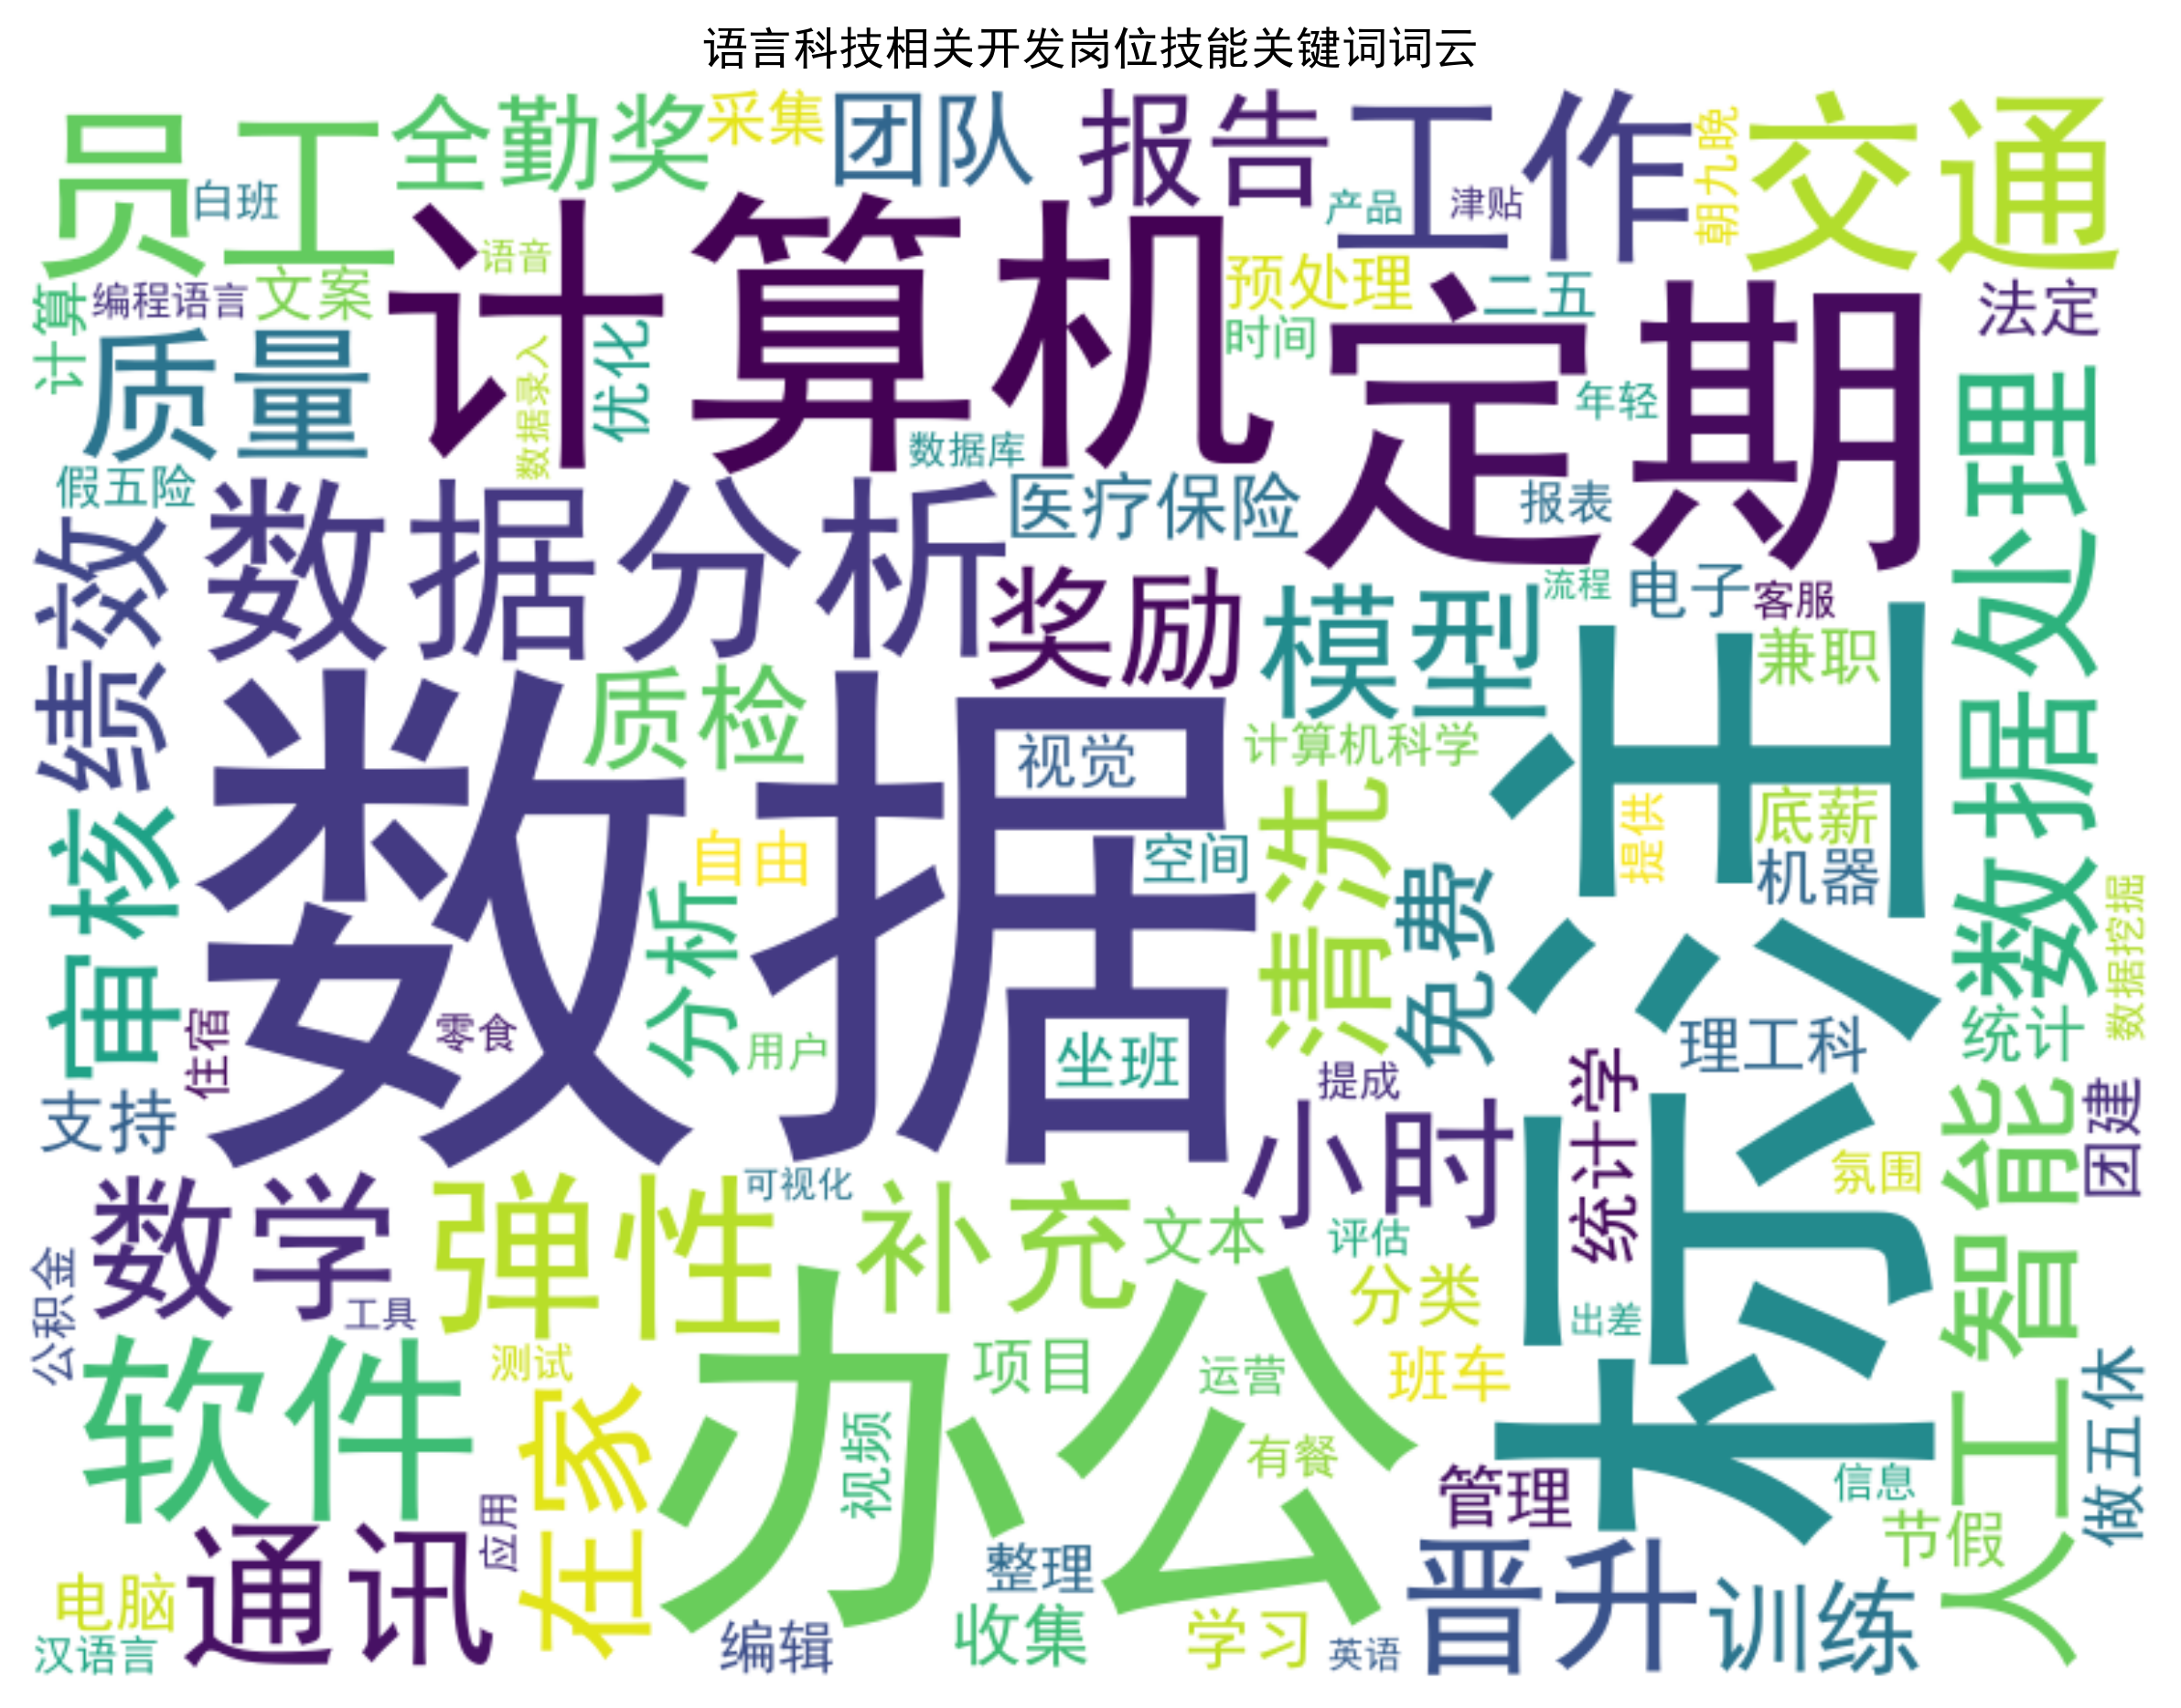

In [24]:
import pandas as pd
import jieba
from collections import Counter
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import re

# 读取CSV文件
df = pd.read_csv('data_51jobs1_filter1.csv')

# 提取职位信息列
job_descriptions = df['职位技能关键词'].dropna().tolist()

# 合并所有文本
all_text = ' '.join(job_descriptions)

# 自定义停用词列表 - 包含福利待遇相关词汇
stopwords = set([
    '五险一金', '带薪年假', '年终奖金', '绩效奖金', '定期体检', '节日福利', '员工旅游', '专业培训',
    '餐饮补贴', '交通补贴', '通讯补贴', '补充医疗保险', '住房补贴', '免费班车', '弹性工作', '周末双休',
    '做五休二', '股票期权', '年终奖', '项目奖金', '出国机会', '零食下午茶', '团建活动', '生日福利',
    '高温补贴', '租房补贴', '免费工作餐', '提供住宿', '出差补贴', '有餐补', '包住', '包吃', '包餐',
    '持证补贴', '交通便利', '发展平台', '团队氛围好', '晋升空间大', '学习平台', '免费体检', '带薪病假',
    '爱心U基金', '六险一金', '六险三金', '补充公积金', '食堂', '宿舍', '下午茶', '节假日', '福利',
    '补贴', '奖金', '保险', '旅游', '体检', '培训', '年假', '病假', '双休', '单休', '大小周','五险',
    '一金','节日','周末','居家','带薪','餐饮',''
])

# 使用jieba进行中文分词
def process_text(text):
    # 去除标点符号和数字
    text = re.sub(r'[^\u4e00-\u9fa5]', ' ', text)
    words = jieba.cut(text)
    # 过滤停用词和单字词
    filtered_words = [word for word in words if len(word) > 1 and word not in stopwords]
    return filtered_words

# 处理所有文本
all_words = []
for desc in job_descriptions:
    all_words.extend(process_text(desc))

# 统计词频
word_counts = Counter(all_words)
top_words = word_counts.most_common(50)

# 打印前50个高频词
print("前50个高频词:")
for word, count in top_words:
    print(f"{word}: {count}")

# 生成词云
font_path = 'C:/Windows/Fonts/simhei.ttf'  # 请确保系统中存在中文字体，或者指定正确路径

wordcloud = WordCloud(
    font_path=font_path,
    width=800,
    height=600,
    background_color='white',
    max_words=100,
    colormap='viridis'
).generate_from_frequencies(word_counts)

# 显示词云图
plt.figure(figsize=(10, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('语言科技相关开发岗位技能关键词词云')
plt.show()

# 保存词云图
wordcloud.to_file('data_jobs_wordcloud.png')